In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path_1 = '/content/drive/My Drive/Dataset_Zeotap/Customers.csv'
file_path_2 = '/content/drive/My Drive/Dataset_Zeotap/Transactions.csv'

customers = pd.read_csv(file_path_1)
transactions = pd.read_csv(file_path_2)

In [6]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [7]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [8]:
# Aggregate transaction data to compute customer metrics
agg_transactions = transactions.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_order_value=("TotalValue", "mean"),
    recency=("TransactionDate", lambda x: (pd.Timestamp.now() - pd.to_datetime(x).max()).days)
).reset_index()

In [9]:
# Merge customer profile and transaction data
customer_data = customers.merge(agg_transactions, on="CustomerID", how="left")

In [11]:
# Handle missing values (if any)
customer_data.fillna(0, inplace=True)

In [12]:
# Select features for clustering
features = ["total_spending", "transaction_count", "avg_order_value", "recency"]
X = customer_data[features]

In [13]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Clustering

In [14]:
# Experiment with different numbers of clusters and calculate metrics
results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    db_index = davies_bouldin_score(X_scaled, labels)
    silhouette_avg = silhouette_score(X_scaled, labels)

    results.append((n_clusters, db_index, silhouette_avg))

In [15]:
# Find the best number of clusters based on the lowest DB Index
results_df = pd.DataFrame(results, columns=["n_clusters", "DB_Index", "Silhouette_Score"])
print("Clustering Metrics:\n", results_df)

Clustering Metrics:
    n_clusters  DB_Index  Silhouette_Score
0           2  1.247220          0.293815
1           3  1.094028          0.315563
2           4  1.018831          0.312233
3           5  1.052444          0.294588
4           6  1.220307          0.249333
5           7  1.187403          0.252866
6           8  1.044715          0.280312
7           9  1.122155          0.254604
8          10  1.071594          0.267650


In [17]:
# Choose the best number of clusters
best_n_clusters = results_df.loc[results_df.DB_Index.idxmin(), "n_clusters"]
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
labels = kmeans.fit_predict(X_scaled)

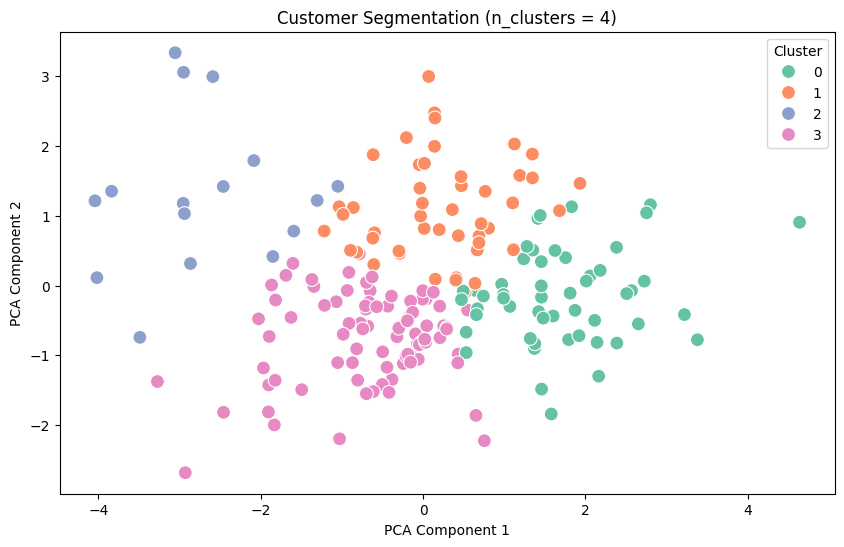

In [18]:
# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", s=100)
plt.title("Customer Segmentation (n_clusters = {})".format(best_n_clusters))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()